Written by Joao Rodrigues

June 2020

Example: Implements a simple, spatially resolved, 2D harmonic oscillator and calculates the steady-state populations and a function of increasing pump power. The idea is to show the occurence of BEC phase transition, and eventually other phase transitions.

Note: All parameters are defined in SI units


In [74]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

## Calculates the cavity modes for a spherical mirror

In [75]:
grid_size = 50.0*1e-6      # meters
grid_delta = 2*1e-6      # meters 
L0 = 1.96*1e-6              # meters 
q = 10                     # longitudinal mode number
n = 2.4
#n=1.43
n_modes = 50
feature_RoC = 0.1   # meters
feature_depth = 0.279*1e-6 # meters

from PyPBEC.Cavity import Modes
cavity_modes = Modes(grid_size=grid_size, grid_delta=grid_delta, L0=L0, q=q, n=n, n_modes=n_modes)
cavity_modes.set_geometry_elliptical(RoC=feature_RoC, depth=feature_depth, anistropy_factor=1.001)
lambdas, modes = cavity_modes.compute_cavity_modes()
g = cavity_modes.get_coupling_matrix()
print(lambdas)

[9.40668715e-07 9.40538758e-07 9.40538631e-07 9.40411296e-07
 9.40411047e-07 9.40408710e-07 9.40286226e-07 9.40285862e-07
 9.40281283e-07 9.40281162e-07 9.40163063e-07 9.40162597e-07
 9.40156248e-07 9.40156012e-07 9.40153769e-07 9.40040714e-07
 9.40040164e-07 9.40033119e-07 9.40032780e-07 9.40028768e-07
 9.40028653e-07 9.39917631e-07 9.39917022e-07 9.39910804e-07
 9.39910381e-07 9.39905672e-07 9.39905455e-07 9.39903685e-07
 9.39792398e-07 9.39791756e-07 9.39787755e-07 9.39787273e-07
 9.39783390e-07 9.39783089e-07 9.39780622e-07 9.39780519e-07
 9.39664417e-07 9.39663767e-07 9.39662556e-07 9.39662042e-07
 9.39660374e-07 9.39660014e-07 9.39658372e-07 9.39658186e-07
 9.39657489e-07 9.39535389e-07 9.39535271e-07 9.39535210e-07
 9.39535188e-07 9.39535144e-07]


## Defines the cavity pump profile

In [76]:
pump_width = 5*1e-6       # meters

X, Y = cavity_modes.get_cavity_grid()
pump_base = np.exp(-((X)**2+Y**2) / pump_width**2)
pump = 1*(pump_base/np.sum(pump_base))
cavity_modes.load_pump(pump=pump)

## Plots the cavity modes and the pump profile

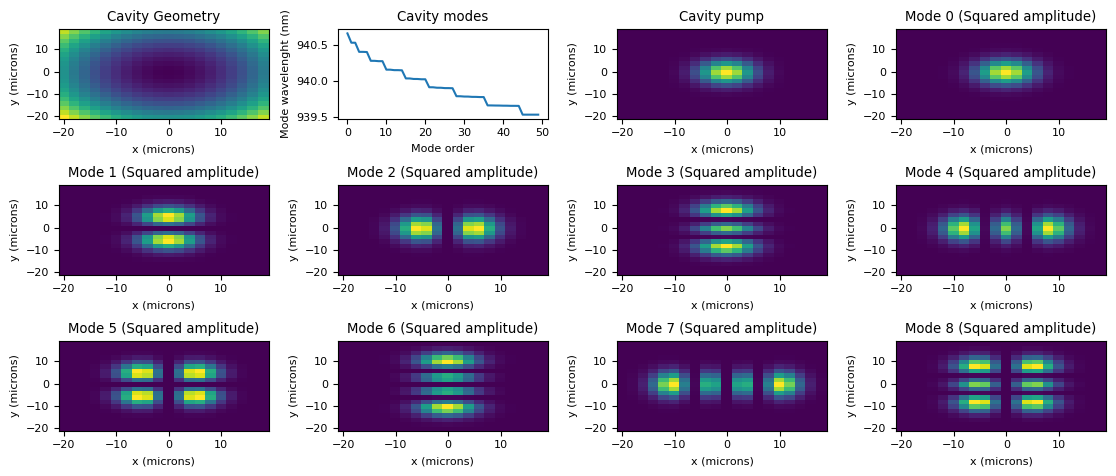

In [77]:
cavity_modes.plot_cavity(start_mode=0)


## Calculates emission and absorption rates from experimental data

C:\Users\natak\OneDrive - Imperial College London\Documents\University\Year 4\MSci Project-r018104\PyPBEC_Semiconductor\PyPBEC\OpticalMedium.py:197: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  abs_sum, _ = quad(absorption_rates_func, 900, 969, args=(mode,))
C:\Users\natak\OneDrive - Imperial College London\Documents\University\Year 4\MSci Project-r018104\PyPBEC_Semiconductor\PyPBEC\OpticalMedium.py:198: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order 

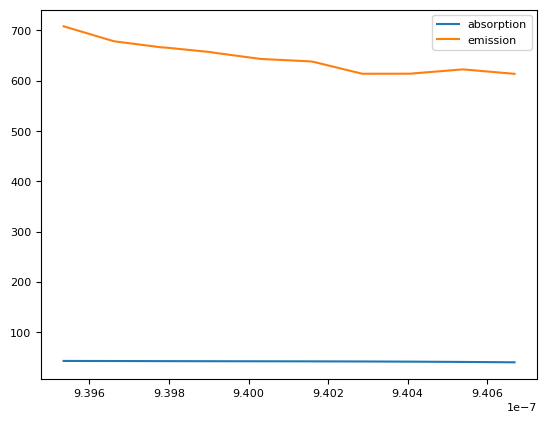

[40.1365327  40.8749015  40.87556433 41.43826126 41.43915449 41.44749376
 41.7998274  41.80065315 41.81095641 41.81122801 42.02341573 42.02408294
 42.03306605 42.0333964  42.03651969 42.17045306 42.17102807 42.17836209
 42.17871319 42.18286394 42.18298202 42.29864998 42.29932863 42.30630983
 42.30678781 42.31214711 42.31239539 42.31442704 42.46690569 42.4679669
 42.4746455  42.47545594 42.48203694 42.48255025 42.48678002 42.48695645
 42.70029734 42.70144194 42.70357105 42.70447238 42.70738777 42.70801533
 42.71086968 42.71119287 42.71240039 42.85957429 42.85962972 42.85965866
 42.85966897 42.85968935]


In [84]:
dye_concentration = 2.0               # in mM, with 1 mM=1mol/m^3

from PyPBEC.OpticalMedium import OpticalMedium
R6G = OpticalMedium(optical_medium="InGaAs_QW")
absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, mode=17)

#R6G = OpticalMedium(optical_medium="Rhodamine6G")
#absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, dye_concentration=dye_concentration, n=n)

plt.plot(lambdas, absorption_rates, label='absorption')
plt.plot(lambdas, emission_rates, label='emission')
plt.legend()
plt.show()

print(absorption_rates)

#### Normalizes the rates, for better numerical performance

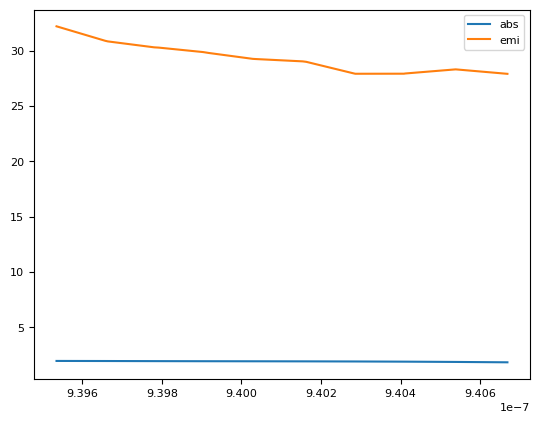

In [85]:
#cavity_loss_rate = 1.0/(10*1e-12)     # in s^-1
cavity_loss_rate = 22     # in s^-1



cavity_loss_rates = np.ones(n_modes)
emission_rates = emission_rates / cavity_loss_rate
absorption_rates = absorption_rates / cavity_loss_rate

plt.plot(lambdas, absorption_rates, label = 'abs')

plt.plot(lambdas, emission_rates, label = 'emi')
plt.legend()
plt.show()

## Defines a cavity

In [80]:
Gamma_down = cavity_loss_rate

# Properties of the photonic modes
from PyPBEC.Cavity import Cavity
cavity = Cavity(M=n_modes, J=g.shape[1])
cavity.set_cavity_loss_rates(rates=cavity_loss_rates)
cavity.set_cavity_emission_rates(rates=emission_rates)
cavity.set_cavity_absorption_rates(rates=absorption_rates)

# Properties of the molecular modes
cavity.set_reservoir_decay_rates(rates=Gamma_down*np.ones(g.shape[1]))
cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
molecular_population = np.array(sc.Avogadro*dye_concentration*(0.5*L0*grid_delta**2)*np.ones(g.shape[1]), dtype=int)
cavity.set_reservoir_population(population=molecular_population)

print(molecular_population)
# Coupling between photonic and molecular modes
cavity.set_coupling_terms(coupling_terms=g)


[4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358 4721358
 4721358 4721358 4721358 4721358 4721358 4721358 47

## Creates the array of pump values

In [81]:
pump_value_min = 100.0
pump_value_max = 1000000.0
n_pump_values = 30

delta_p = (pump_value_max/pump_value_min)**(1/n_pump_values)-1
pumps = [(1+delta_p)**i*pump_value_min for i in range(0, n_pump_values)]

## Solves the mean-field steady-state

In [82]:
from PyPBEC.Solver import SteadyState
from tqdm import tqdm
populations = list()
for value in tqdm(pumps):
    # loads the pump onto the cavity object
    pump = value*(pump_base/np.sum(pump_base))
    cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
    
    # Steady-state solver
    solver_steadystate = SteadyState(cavity_obj=cavity, ANNEALING=False)
    # Defines the initial guess
    if value==pumps[0]:
        solver_steadystate.set_initial_photons(initial_photons=np.array(np.zeros(cavity.M)))
        solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(np.zeros(cavity.J)))  
    else:
        solver_steadystate.set_initial_photons(initial_photons=np.array(solved_cavity_steadystate.photons[-1]))
        solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(solved_cavity_steadystate.emols[-1])) 
    
    # Calls the solver
    solved_cavity_steadystate = solver_steadystate.solve()
    
    # Sums the populations over the mode degeneracy, g=n+1, with n=0,1,2,...
    mode_degeneracy = np.array([j for j in range(0, n_modes) for i in range(0, j)][0:n_modes])
    steady_state_photon_population = [np.sum(solved_cavity_steadystate.photons[:,np.where(mode_degeneracy==mode_number)[0]], 1) 
        for mode_number in list(set(list(mode_degeneracy)))]
    steady_state_photon_population = np.transpose(np.array(steady_state_photon_population))
    
    # Appends
    populations.append(steady_state_photon_population)
populations = np.array(populations)

100%|██████████| 30/30 [02:07<00:00,  4.25s/it]


## Plots the results

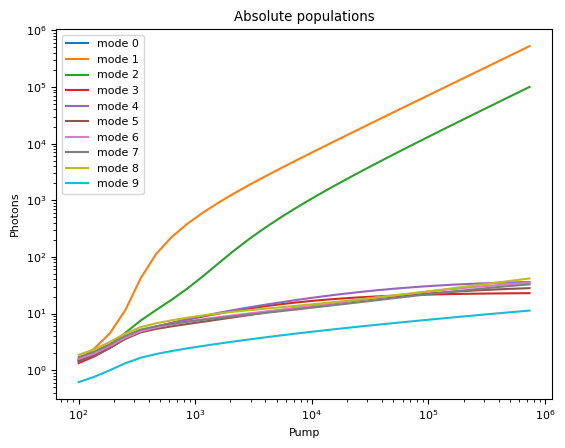

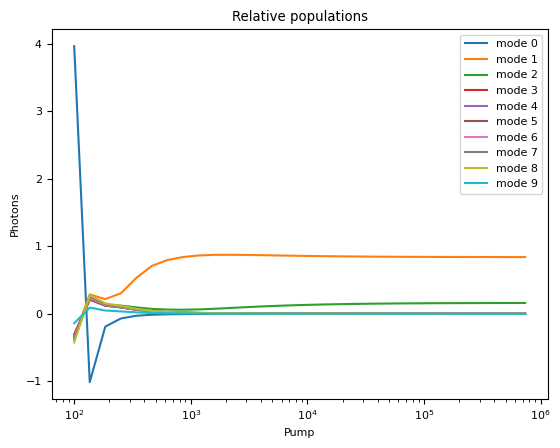

In [83]:
populations = np.squeeze(populations)

[plt.plot(pumps, populations[:,i], label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.yscale("log")
plt.title("Absolute populations")
plt.show()

[plt.plot(pumps, populations[:,i]/np.sum(populations,1), label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.title("Relative populations")
plt.show()